This notebook generates and saves tissue, spatial, and network features for the samples using functions from the helper files and produces visualizations

Individual cells can be run using the data in the saved pickle objects to re-produce or edit visualizations without re-running feature generation.

Author: Lucy Van Kleunen

In [1]:
# Loaded needed libraries
import csv
import numpy as np
from matplotlib import pyplot as plt
import networkx as nx
import pickle
import pandas as pd
import seaborn as sns
import os
from scipy import stats
import statsmodels.stats.multitest as smt
import spatial_net_helper
import viz_helper

In [2]:
### Make figure folders to save visualizations
for i in range(2,8):
    if not os.path.exists(f"Figure_{i}"):
        os.mkdir(f"Figure_{i}")
if not os.path.exists("Dot_Maps"):
    os.mkdir("Dot_Maps")
if not os.path.exists(os.path.join("Figure_2","Percentage_Correlations")):
    os.mkdir(os.path.join("Figure_2","Percentage_Correlations"))
if not os.path.exists(os.path.join("Figure_3", "Net_Creation")):
    os.mkdir(os.path.join("Figure_3", "Net_Creation"))
if not os.path.exists(os.path.join("Figure_3","Net_Properties")):
    os.mkdir(os.path.join("Figure_3","Net_Properties"))

In [2]:
# Constants (used throughout the notebook)
SPATIAL_NET_THRESHOLD = 50 # distance threshold for trimming a spatial link between neighboring cells (in pixels)
#SPATIAL_NET_THRESHOLD = 100 # sensitivity test with increased spatial network threshold
MICRON = 0.488 # conversion from pixels to microns
DATA_FILE = os.path.join('Data','cell_table.csv')
# Names of the cell types used as focal cell types to generate features
TUMOR = "Tumor"
M1 = "M1 macrophages" 
VASCULAR = "Vascular endothelial cells"

In [4]:
### Read in and save tumor sample data into two dictionaries keyed by sample id that are used throughout the notebook
points = {} # dictionary  {fov_int : [list of points x, y coordinates listed as (centroid 0, centroid 1)]}
cell_types = {} # dictionary {fov_int : [list of point cell type classifications]}

# asserts to make sure we have the correct indices for the given columns in the cell table
cell_df = pd.read_csv(DATA_FILE)
FOV_INT_INDEX = cell_df.columns.get_loc('fov_int')
CENTROID_0_INDEX = cell_df.columns.get_loc('centroid-0')
CENTROID_1_INDEX = cell_df.columns.get_loc('centroid-1')
CELL_TYPE_INDEX = cell_df.columns.get_loc('CellType')

unique_types = []
# This file is a list of points (cells) along with their antibody levels and cell type classifications
with open(DATA_FILE) as fileobj:
    reader = csv.reader(fileobj)
    next(reader) # skip header
    # Each row in the file is a single identified cell
    for row in reader:
        fov_int = int(row[FOV_INT_INDEX]) # This column identifies which sample the point belongs to via a unique integer id
        # Add this point to the points dictionary, keyed by fov_int
        if fov_int not in points:
            points[fov_int] = []
        centroid_0 = float(row[CENTROID_0_INDEX])
        centroid_1 = float(row[CENTROID_1_INDEX])
        points[fov_int].append([centroid_0,centroid_1]) # add cell centroid location to dictionary

        if fov_int not in cell_types:
            cell_types[fov_int] = []
        curr_type = row[CELL_TYPE_INDEX]
        cell_types[fov_int].append(curr_type) # add cell type to dictionary
        
        if curr_type not in unique_types:
            unique_types.append(curr_type)
                
# Double check to make sure the points and cell types objects are the same length each sample
number_cells = 0 # count total cells in the dictionaries
for point_key in points:
    assert len(points[point_key]) == len(cell_types[point_key]), "points and cell types don't match"
    number_cells += len(points[point_key])
assert number_cells == len(cell_df['CellType']), "problem with cell type number"
    
print(f"number of cells: {number_cells}")
print(f"number of unique fovs: {len(points.keys())}")
print(f"number of unique cell types: {len(unique_types)}, which are: {unique_types}")
type_colors = viz_helper.get_cell_type_colors()
assert set(type_colors.keys()) == set(unique_types), "type colors names and unique types in cell table don't match"
# Save objects used throughout the notebook
with open(os.path.join('analysis_objects','points.pickle'), 'wb') as handle:
    pickle.dump(points, handle)
with open(os.path.join('analysis_objects','cell_types.pickle'), 'wb') as handle:
    pickle.dump(cell_types, handle)

number of cells: 160532
number of unique fovs: 83
number of unique cell types: 24, which are: ['CD8+ T cells', 'CD4+ T cells', 'NK/NKT', 'CD56+CD45-', 'Vascular endothelial cells', 'Lymphatic endothelial cells', 'Fibroblast', 'Tumor', 'Unidentified', 'B cells', 'M2 macrophages', 'M1 macrophages', 'Dendritic cells', 'CD163+ cells', 'Monocytes', 'CD11c_low immune', 'Other immune', 'Neuroepithelial cells', 'Non-leukocyte derived neural cells', 'CD11b+ epithelial', 'Neutrophils', 'CD11c+ epithelial', 'CD11b_low Neutrophils', 'HLADR+']


In [5]:
# Cell type counts / distributions across and within the samples 
with open(os.path.join('analysis_objects','points.pickle'), 'rb') as handle:
    points = pickle.load(handle)
with open(os.path.join('analysis_objects','cell_types.pickle'), 'rb') as handle:
    cell_types = pickle.load(handle)

type_colors = viz_helper.get_cell_type_colors()
unique_types = list(type_colors.keys())
    
# Dictionaries saving important information about cell type counts for reporting / visualization
fov_types = {} # fov_int : number of unique cell types in the sample 
type_counts = {} # cell type : count of samples that type is in
type_aggregate = {} # cell type: count of cells of that type, aggregated across all samples 
cell_counts = {} # fov_int : number of cells in the sample
type_props = {} # fov_int : {cell type: proportion in the sample}
for typee in unique_types: # loop through unique cell types and initialize
    type_counts[typee] = 0 
    type_aggregate[typee] = 0
for fov_int in points.keys():
    cell_counts[fov_int] = len(points[fov_int]) # Number of cells in the sample
    type_set = set(cell_types[fov_int]) # Set of unique cell types for the sample
    fov_types[fov_int] = len(type_set) # Number of unique cell types for the sample
    for typee in cell_types[fov_int]: # Loop through the types of all the cells in the sample
        type_aggregate[typee] += 1 # Increase the running counts for each type across all cells
    type_props[fov_int] = {}
    for typee in unique_types: # For all possible cell types
        if typee in type_set: # If the cell type is in this sample 
            type_counts[typee] += 1 # Increase the sample count for this cell type
            # Record the proportion for this cell type in this sample (out of number of points in the sample)
            type_props[fov_int][typee] = cell_types[fov_int].count(typee)/len(points[fov_int])
        else:
            type_props[fov_int][typee] = 0 # Proportion is 0 if the cell type isn't in the sample
        
# Save the newly generated objects for visualizations  
with open(os.path.join('analysis_objects','fov_types.pickle'), 'wb') as handle:
    pickle.dump(fov_types, handle)
with open(os.path.join('analysis_objects','type_counts.pickle'), 'wb') as handle:
    pickle.dump(type_counts, handle)
with open(os.path.join('analysis_objects','type_aggregate.pickle'), 'wb') as handle:
    pickle.dump(type_aggregate, handle)
with open(os.path.join('analysis_objects','cell_counts.pickle'), 'wb') as handle:
    pickle.dump(cell_counts, handle)
with open(os.path.join('analysis_objects','type_props.pickle'), 'wb') as handle:
    pickle.dump(type_props, handle)

ID TO CHECK 35 -- 0.1655087862689007
ID TO CHECK 20 -- 0.1717983043284248
fov_int under 0 proportion Tumor: 27, 0
ID TO CHECK 34 -- 0.05606523955147808
fov_int over 0.65 proportion Unidentified: 26, 0.7732871439568899
fov_int over 0.65 proportion Unidentified: 45, 0.9262101534828807
fov_int under 0 proportion Tumor: 45, 0
fov_int under 0 proportion Tumor: 29, 0
ID TO CHECK 19 -- 0.557683325548809


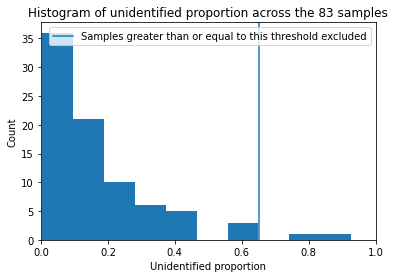

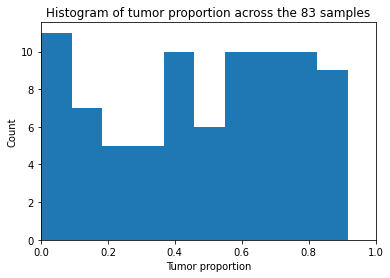

In [6]:
### Histogram of Unidentified proportion -- used to exclude some outlier samples from further analysis

EXCLUDE_THRESHOLD_1 = 0.65
EXCLUDE_THRESHOLD_2 = 0

with open(os.path.join('analysis_objects','points.pickle'), 'rb') as handle:
    points = pickle.load(handle)
with open(os.path.join('analysis_objects','type_props.pickle'), 'rb') as handle:
    type_props = pickle.load(handle)
    
# Check specificallly based on the fov's of samples coming from the same TMA ID to decide which one to use
ids_to_check = [19,20,34,35]
    
uni_props = []
tum_props = []
for fov_int in points.keys():
    uni_prop = type_props[fov_int]["Unidentified"]
    tum_prop = type_props[fov_int]["Tumor"]
    uni_props.append(uni_prop)
    tum_props.append(tum_prop)
    if fov_int in ids_to_check:
        print(f"ID TO CHECK {fov_int} -- {uni_prop}")
    if uni_prop >= EXCLUDE_THRESHOLD_1:
        print(f"fov_int over {EXCLUDE_THRESHOLD_1} proportion Unidentified: {fov_int}, {uni_prop}")
    if tum_prop <= EXCLUDE_THRESHOLD_2:
        print(f"fov_int under {EXCLUDE_THRESHOLD_2} proportion Tumor: {fov_int}, {tum_prop}")
        
# Histogram of Unidentified proportion
plt.title(f"Histogram of unidentified proportion across the {len(points.keys())} samples")
plt.hist(uni_props)
plt.xlim([0,1])
plt.xlabel("Unidentified proportion")
plt.ylabel("Count")
plt.axvline(x=EXCLUDE_THRESHOLD_1, label="Samples greater than or equal to this threshold excluded")
plt.legend()
plt.savefig(os.path.join('Figure_2','unidentified_props.png'),dpi=1000,bbox_inches='tight')
plt.show()

# Histogram of Tumor proportion
plt.title(f"Histogram of tumor proportion across the {len(points.keys())} samples")
plt.hist(tum_props)
plt.xlim([0,1])
plt.xlabel("Tumor proportion")
plt.ylabel("Count")
plt.savefig(os.path.join('Figure_2','tumor_props.png'),dpi=1000,bbox_inches='tight')
plt.show()

In [7]:
#### Excluding some of the samples and re-saving the analysis objects

# The samples where Unidentified proportion is over 0.65: 45, 26
# Samples with no tumor cells: 27, 29, 45
# Below chosen based on Unidentified proportion:
# Only using one sample per patient, so excluding fov_int 35 to only include 34 for patient w/ TMA 124 
# Only using one sample per patient, so excluding fov_int 19 to only include 20 for patient w/ TMA 103
IDS_TO_EXCLUDE = [19,26,27,29,35,45]
    
# Loading objects keyed by fov_int to exclude those samples and re-save trimmed versions
with open(os.path.join('analysis_objects','points.pickle'), 'rb') as handle:
    points = pickle.load(handle)
with open(os.path.join('analysis_objects','cell_types.pickle'), 'rb') as handle:
    cell_types = pickle.load(handle)
with open(os.path.join('analysis_objects','fov_types.pickle'), 'rb') as handle:
    fov_types = pickle.load(handle)
with open(os.path.join('analysis_objects','cell_counts.pickle'), 'rb') as handle:
    cell_counts = pickle.load(handle)
with open(os.path.join('analysis_objects','type_props.pickle'), 'rb') as handle:
    type_props = pickle.load(handle)
        
# Create new versions with the ids excluded
for idi in IDS_TO_EXCLUDE:
    points.pop(idi)
    cell_types.pop(idi)
    fov_types.pop(idi)
    cell_counts.pop(idi)
    type_props.pop(idi)

# Save the new versions as well (so we can make visualizations quickly with and without excluded samples)
with open(os.path.join('analysis_objects','points_trimmed.pickle'), 'wb') as handle:
    pickle.dump(points, handle)
with open(os.path.join('analysis_objects','cell_types_trimmed.pickle'), 'wb') as handle:
    pickle.dump(cell_types, handle)
with open(os.path.join('analysis_objects','fov_types_trimmed.pickle'), 'wb') as handle:
    pickle.dump(fov_types, handle)
with open(os.path.join('analysis_objects','cell_counts_trimmed.pickle'), 'wb') as handle:
    pickle.dump(cell_counts, handle)
with open(os.path.join('analysis_objects','type_props_trimmed.pickle'), 'wb') as handle:
    pickle.dump(type_props, handle)

# Objects that need to be fully re-calculated
type_colors = viz_helper.get_cell_type_colors()
unique_types = list(type_colors.keys())
          
type_counts = {} # cell type : count of samples that type is in
type_aggregate = {} # cell type: count of cells of that type, aggregated across all samples 
for typee in unique_types:
    type_counts[typee] = 0 
    type_aggregate[typee] = 0
for fov_int in points.keys(): # using trimmed version of points
    for typee in cell_types[fov_int]: # using trimmed version of cell_types
        type_aggregate[typee] += 1
    type_set = set(cell_types[fov_int])
    for typee in unique_types:
        if typee in type_set:
            type_counts[typee] += 1
            
# Save the new trimmed versions
with open(os.path.join('analysis_objects','type_counts_trimmed.pickle'), 'wb') as handle:
    pickle.dump(type_counts, handle)
with open(os.path.join('analysis_objects','type_aggregate_trimmed.pickle'), 'wb') as handle:
    pickle.dump(type_aggregate, handle)

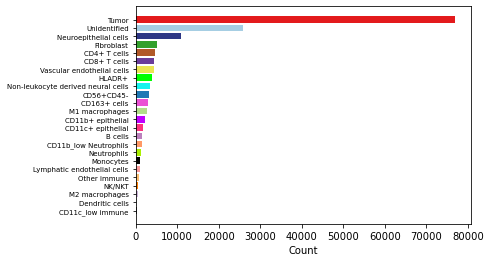

A few of the type counts (N=83):
Tumor cells: 76778
Unidentified cells: 25777
M1 macrophages: 2836
M2 macrophages: 454
CD163+ cells: 2851


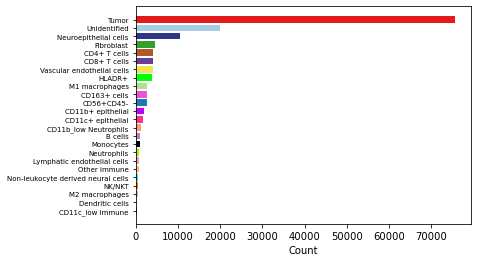

In [8]:
### Figure with and without excluded id's -- Counts of cell types across the entire dataset

type_colors = viz_helper.get_cell_type_colors()

with open(os.path.join('analysis_objects','type_aggregate.pickle'), 'rb') as handle:
    type_aggregate = pickle.load(handle)
with open(os.path.join('analysis_objects','type_aggregate_trimmed.pickle'), 'rb') as handle:
    type_aggregate_trimmed = pickle.load(handle)
    
# ACROSS ALL 83 SAMPLES
type_aggregate_sorted = dict(sorted(type_aggregate.items(), key=lambda x:x[1]))

plot_colors = []
tick_labels = []
for sk in type_aggregate_sorted:
    plot_colors.append(type_colors[sk])
    tick_labels.append(sk)

plt.barh(np.arange(len(type_aggregate_sorted.keys())),list(type_aggregate_sorted.values()), color=plot_colors,\
         tick_label=tick_labels)
plt.yticks(fontsize=7)
plt.xlabel("Count")
plt.savefig(os.path.join('Figure_2','2A_all.png'),dpi=1000,bbox_inches='tight')
plt.show()

print("A few of the type counts (N=83):")
print(f"Tumor cells: {type_aggregate_sorted['Tumor']}")
print(f"Unidentified cells: {type_aggregate_sorted['Unidentified']}")
print(f"M1 macrophages: {type_aggregate_sorted['M1 macrophages']}")
print(f"M2 macrophages: {type_aggregate_sorted['M2 macrophages']}")
print(f"CD163+ cells: {type_aggregate_sorted['CD163+ cells']}")

# ACROSS THE FINAL 77 SAMPLES ONLY
type_aggregate_trimmed_sorted = dict(sorted(type_aggregate_trimmed.items(), key=lambda x:x[1]))

plot_colors = []
tick_labels = []
for sk in type_aggregate_trimmed_sorted:
    plot_colors.append(type_colors[sk])
    tick_labels.append(sk)

plt.barh(np.arange(len(type_aggregate_trimmed_sorted.keys())),list(type_aggregate_trimmed_sorted.values()), \
         color=plot_colors, tick_label=tick_labels)
plt.yticks(fontsize=7)
plt.xlabel("Count")
plt.savefig(os.path.join('Figure_2','2A_trimmed.png'),dpi=1000,bbox_inches='tight')
plt.show()

In [10]:
## Save Dot Maps of all the samples (note excluded)
with open(os.path.join('analysis_objects','points.pickle'), 'rb') as handle:
    points = pickle.load(handle)
with open(os.path.join('analysis_objects','cell_types.pickle'), 'rb') as handle:
    cell_types = pickle.load(handle)
type_colors = viz_helper.get_cell_type_colors()
IDS_TO_EXCLUDE = [19,26,27,29,35,45]
    
folder = 'Dot_Maps'
for fov_int in points.keys():
    if fov_int in IDS_TO_EXCLUDE:
        excluded = True
    else:
        excluded = False
    viz_helper.visualize_sample(fov_int,excluded,folder,points,cell_types,False)

Average percentage Tumor : 47.80127230610638
Average percentage Unidentified : 16.656309928826605
Average percentage Neuroepithelial cells : 6.372635431801917
Average percentage Fibroblast : 3.2870621537599543
Average percentage CD4+ T cells : 2.8613211412303374
Average percentage CD8+ T cells : 2.7897453943674284
Average percentage Vascular endothelial cells : 2.7700365862712824
Average percentage HLADR+ : 2.0519470986869655
Average percentage Non-leukocyte derived neural cells : 1.2606572132411353
Average percentage CD56+CD45- : 1.685660761570921
Average percentage CD163+ cells : 1.9627485921987886
Average percentage M1 macrophages : 1.8311065627721874
Average percentage CD11b+ epithelial : 1.4964798290130965
Average percentage CD11c+ epithelial : 1.0021306775119398
Average percentage B cells : 0.9696125775732105
Average percentage CD11b_low Neutrophils : 1.0050614176692283
Average percentage Neutrophils : 1.2021131194290446
Average percentage Monocytes : 0.6711796834150862
Average p

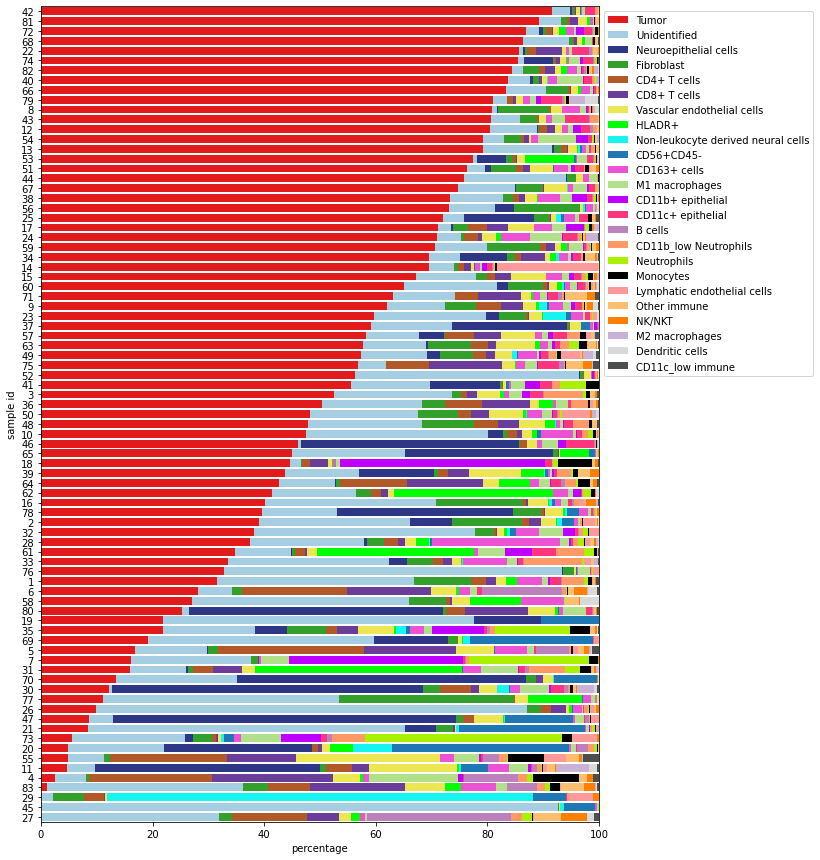

Average percentage Tumor : 50.831782671088796
Average percentage Unidentified : 14.365417423539062
Average percentage Neuroepithelial cells : 6.63787193996745
Average percentage Fibroblast : 3.3171764853643464
Average percentage CD4+ T cells : 2.813533675940122
Average percentage CD8+ T cells : 2.8440749386700923
Average percentage Vascular endothelial cells : 2.8595869103849396
Average percentage HLADR+ : 2.1813385294567986
Average percentage M1 macrophages : 1.9462492530777247
Average percentage CD163+ cells : 2.04479482514415
Average percentage CD56+CD45- : 1.5229979576229673
Average percentage CD11b+ epithelial : 1.4910202779570472
Average percentage CD11c+ epithelial : 1.0715536915090846
Average percentage CD11b_low Neutrophils : 1.0315749245148338
Average percentage B cells : 0.7018311838773539
Average percentage Monocytes : 0.6696160896489022
Average percentage Neutrophils : 1.0963107108024708
Average percentage Lymphatic endothelial cells : 0.6581841528000683
Average percentage

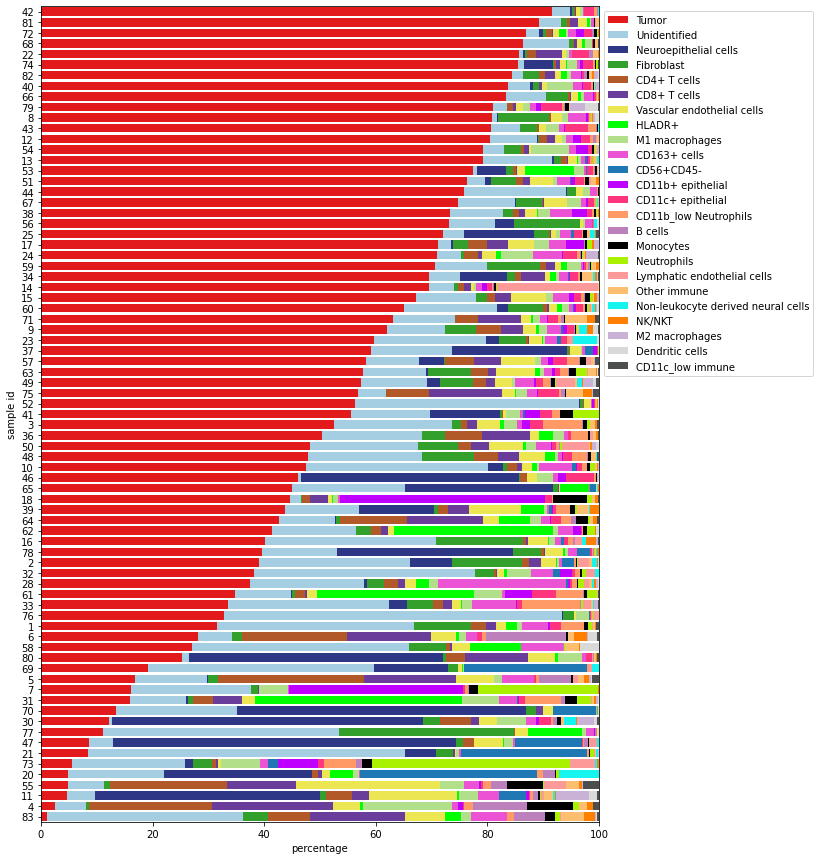

In [11]:
## Cell type proportions across samples (with and without excluded samples)

type_colors = viz_helper.get_cell_type_colors()

# Function to create stacked bar plots of cell type proportion and also save a text file with the same data
def cell_type_proportions_stacked(cell_types, type_aggregate, points, suffix, prop_file):

    # re-arrange type colors by overall prevalence in the dataset
    type_aggregate_sorted = dict(sorted(type_aggregate.items(), key=lambda x:x[1],reverse=True))
    type_colors_ordered = {}
    for tk in type_aggregate_sorted:
        type_colors_ordered[tk] = type_colors[tk] 

    labels = list(type_colors_ordered.keys()) # cell types list 
    colors = list(type_colors_ordered.values()) # cell types colors 

    type_countz_all = {}
    tumor_perc = {}
    for pk in points.keys():
        type_countz = {item: cell_types[pk].count(item) for item in cell_types[pk]}
        # change to a percent
        for tk in labels:
            if tk in type_countz:
                type_countz[tk] = type_countz[tk]/len(cell_types[pk])*100
            else:
                type_countz[tk] = 0
        type_countz_all[pk] = type_countz
        tumor_perc[pk] = type_countz['Tumor']

    # sort by the percent of tumor cells, descending 
    tumor_perc_sorted = dict(sorted(tumor_perc.items(), key=lambda x:x[1]))
    
    # Print average percentages of all the cell types 
    # This includes samples for which the percent is 0 
    for tk in type_colors_ordered.keys():
        avg_perc = 0
        min_perc = 1000
        max_perc = 0 
        for pk in type_countz_all.keys():
            curr_perc = type_countz_all[pk][tk]
            avg_perc += curr_perc
            if curr_perc > max_perc:
                max_perc = curr_perc
            if curr_perc < min_perc:
                min_perc = curr_perc
        avg_perc = avg_perc / len(type_countz_all.keys())
        print(f"Average percentage {tk} : {avg_perc}")
        out_file.write(f"Average percentage {tk} : {avg_perc}, min perc: {min_perc}, max_perc: {max_perc} \n")

    fig, ax = plt.subplots(1, figsize=(10, 15))
    j = 0
    sample_order = []
    for pk in tumor_perc_sorted.keys():
        sample_order.append(pk)
        type_countz =  type_countz_all[pk]
        left = 0
        # get these in the right order 
        for i in range(0, len(labels)):
            tk = labels[i]
            wid = type_countz[tk]
            plt.barh(j, wid, left=left, color=colors[i])
            left = left + wid
        j += 1

    plt.legend(labels, bbox_to_anchor=([1, 1, 0, 0]))
    plt.xlabel("percentage")
    plt.ylabel("sample id")
    plt.ylim(-0.5,len(tumor_perc_sorted.keys())-0.5)
    plt.yticks(range(0,len(tumor_perc_sorted.keys())),sample_order) 
    plt.savefig(os.path.join('Figure_2',f'2B_{suffix}.png'),dpi=1000,bbox_inches='tight')
    plt.show()
    

# With all samples
with open (os.path.join('Figure_2','prop_out_all.txt'),'w') as out_file: 
    with open(os.path.join('analysis_objects','cell_types.pickle'), 'rb') as handle:
        ct = pickle.load(handle)
    with open(os.path.join('analysis_objects','type_aggregate.pickle'), 'rb') as handle:
        ta = pickle.load(handle)
    with open(os.path.join('analysis_objects','points.pickle'), 'rb') as handle:
        pts = pickle.load(handle)
    cell_type_proportions_stacked(ct, ta, pts, 'all', out_file)

# Without excluded samples 
with open (os.path.join('Figure_2','prop_out_trimmed.txt'),'w') as out_file: 
    with open(os.path.join('analysis_objects','cell_types_trimmed.pickle'), 'rb') as handle:
        ct = pickle.load(handle)
    with open(os.path.join('analysis_objects','type_aggregate_trimmed.pickle'), 'rb') as handle:
        ta = pickle.load(handle)
    with open(os.path.join('analysis_objects','points_trimmed.pickle'), 'rb') as handle:
        pts = pickle.load(handle)
    cell_type_proportions_stacked(ct, ta, pts, 'trimmed', out_file)

In [13]:
## Correlation coefficients between cell type percentages (with excluded samples)

with open(os.path.join('analysis_objects','type_props.pickle'), 'rb') as handle:
    type_props = pickle.load(handle)

# create dictionary where sorted by cell type rather than sample
type_prop_vectors = {}
type_prop_vectors_trimmed = {}
for sample_id in type_props.keys():
    for cell_type in type_props[sample_id]:
        curr_prop = type_props[sample_id][cell_type]
        if cell_type not in type_prop_vectors:
            type_prop_vectors[cell_type] = [curr_prop*100]
        else:
            type_prop_vectors[cell_type].append(curr_prop*100)
                
# Generate correlation coefficients between tumor cell percentage and other cell type percentages 
tumor_props = type_prop_vectors['Tumor']
p_vals = []
cts = []
corr_coeff_out = {'cell_type': [], 'r': [], 'p': [], 'p-adjusted': [], 'significant': []}
for cell_type in type_prop_vectors.keys():
    if cell_type != 'Tumor':
        curr_props = type_prop_vectors[cell_type]
        # in this version of scipy the default is a two-sided test (against null of no correlation / 0 score)
        pearson_res = stats.pearsonr(tumor_props, curr_props)
        corr_ceoff = round(pearson_res[0],3)
        p_value = round(pearson_res[1],3)
        p_vals.append(p_value)
        cts.append(cell_type)
        sig = 'Yes' if p_value < 0.05 else 'No'
        
        corr_coeff_out['cell_type'].append(cell_type)
        corr_coeff_out['r'].append(corr_ceoff)
        corr_coeff_out['p'].append(p_value)
        
        # visualize relationship and save file with information
        fig = plt.figure()
        plt.scatter(tumor_props, curr_props)
        plt.xlabel('Tumor percentage')
        plt.ylabel(f'{cell_type} percentage')
        img_name = os.path.join('Figure_2','Percentage_Correlations',f'{cell_type.replace("/",".") }_Tumor_Corr.png')
        plt.savefig(img_name,dpi=1000,bbox_inches='tight')
        plt.close(fig)
        
        info_str = f"Cell type: {cell_type}, Correlation coefficient: {corr_ceoff}, two-sided p-val: {p_value}, significant: {sig}"
        print(info_str)
        
p_vals_corrected = smt.fdrcorrection(p_vals)
for i in range(0,len(cts)):
    ctt = cts[i]
    corr_coeff_out['p-adjusted'].append(p_vals_corrected[1][i])
    corr_coeff_out['significant'].append(p_vals_corrected[0][i])
    print(f"{ctt} adjusted p-value: {p_vals_corrected[1][i]} , significant: {p_vals_corrected[0][i]}")
    
cc_df = pd.DataFrame(corr_coeff_out)
cc_df.to_csv(os.path.join('Figure_2','Percentage_Correlations','correlation_coefficients_tumor.csv'))

Cell type: CD8+ T cells, Correlation coefficient: -0.311, two-sided p-val: 0.004, significant: Yes
Cell type: CD4+ T cells, Correlation coefficient: -0.379, two-sided p-val: 0.0, significant: Yes
Cell type: NK/NKT, Correlation coefficient: -0.303, two-sided p-val: 0.005, significant: Yes
Cell type: CD56+CD45-, Correlation coefficient: -0.401, two-sided p-val: 0.0, significant: Yes
Cell type: Vascular endothelial cells, Correlation coefficient: -0.29, two-sided p-val: 0.008, significant: Yes
Cell type: Lymphatic endothelial cells, Correlation coefficient: -0.071, two-sided p-val: 0.525, significant: No
Cell type: Fibroblast, Correlation coefficient: -0.108, two-sided p-val: 0.332, significant: No
Cell type: Unidentified, Correlation coefficient: -0.498, two-sided p-val: 0.0, significant: Yes
Cell type: B cells, Correlation coefficient: -0.339, two-sided p-val: 0.002, significant: Yes
Cell type: M2 macrophages, Correlation coefficient: -0.084, two-sided p-val: 0.451, significant: No
Cell

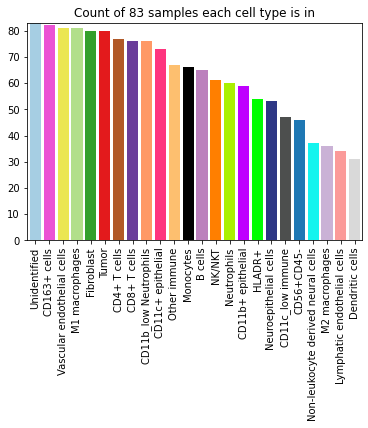

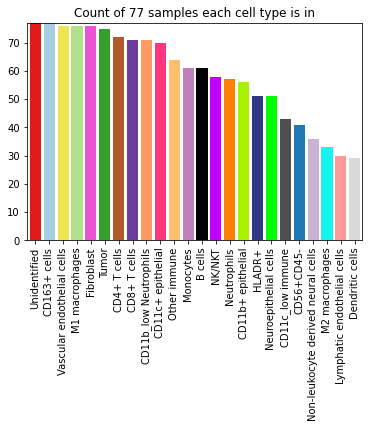

In [14]:
## Figure - Count of samples each cell type is in (save for full dataset and trimmed)
with open(os.path.join('analysis_objects','points.pickle'), 'rb') as handle:
    points = pickle.load(handle)
with open(os.path.join('analysis_objects','points_trimmed.pickle'), 'rb') as handle:
    points_trimmed = pickle.load(handle)
with open(os.path.join('analysis_objects','type_counts.pickle'), 'rb') as handle:
    type_counts = pickle.load(handle)
with open(os.path.join('analysis_objects','type_counts_trimmed.pickle'), 'rb') as handle:
    type_counts_trimmed = pickle.load(handle)
    
type_colors = viz_helper.get_cell_type_colors()

# FOR ALL 83 SAMPLES
# Counts of samples each cell type is in - all 
type_counts_sorted = dict(sorted(type_counts.items(), key=lambda x:x[1], reverse=True)) # sort by count
# get colors in the right order too
plot_colors = []
for key in type_counts_sorted:
    plot_colors.append(type_colors[key])
plt.title(f"Count of {len(points.keys())} samples each cell type is in")
labels = list(type_counts_sorted.keys())
plt.bar(range(0,len(type_counts_sorted.keys())),type_counts_sorted.values(),tick_label=labels,color=plot_colors)
plt.ylim([0,len(points.keys())])
plt.xlim([-0.6,len(type_counts_sorted.keys())-0.5])
plt.xticks(rotation=90)
plt.savefig(os.path.join('Figure_2','2_C_all.png'),dpi=1000,bbox_inches='tight')
plt.show()

# Save to text file as well for reporting in the paper
with open (os.path.join('Figure_2','sample_types_count_all.txt'),'w') as out_file: 
    for typee in type_counts_sorted.keys():
        out_file.write(f"type: {typee}, sample count: {type_counts[typee]}\n")

# FOR FINAL 77 SAMPLES
# Counts of samples each cell type is in - trimmed
type_counts_trimmed_sorted = dict(sorted(type_counts_trimmed.items(), key=lambda x:x[1], reverse=True)) # sort by count
plot_colors = []
for key in type_counts_trimmed_sorted:
    plot_colors.append(type_colors[key])
plt.title(f"Count of {len(points_trimmed.keys())} samples each cell type is in")
plt.bar(range(0,len(type_counts_trimmed_sorted.keys())),type_counts_trimmed_sorted.values(),tick_label=labels,color=plot_colors)
plt.ylim([0,len(points_trimmed.keys())])
plt.xlim([-0.6,len(type_counts_trimmed_sorted.keys())-0.5])
plt.xticks(rotation=90)
plt.savefig(os.path.join('Figure_2','2_C_trimmed.png'),dpi=1000,bbox_inches='tight')
plt.show()

with open (os.path.join('Figure_2','sample_types_count_trimmed.txt'),'w') as out_file: 
    for typee in type_counts_trimmed_sorted.keys():
        out_file.write(f"type: {typee}, sample count: {type_counts_trimmed[typee]}\n")

In [15]:
## Spatial feature generation (using only the final set of samples)

with open(os.path.join('analysis_objects','points_trimmed.pickle'), 'rb') as handle:
    points = pickle.load(handle)
with open(os.path.join('analysis_objects','cell_types_trimmed.pickle'), 'rb') as handle:
    cell_types = pickle.load(handle)

# Median (spatial) distance from X cells to nearest neighbor cells of each other cell type in a sample 
median_distances_tumor = {}
median_distances_M1 = {}
median_distances_vascular = {}
for pk in points.keys():
    median_distances_tumor[pk] = spatial_net_helper.generate_median_distances(pk, points, cell_types, TUMOR)
    median_distances_M1[pk] = spatial_net_helper.generate_median_distances(pk, points, cell_types, M1)
    median_distances_vascular[pk] = spatial_net_helper.generate_median_distances(pk, points, cell_types, VASCULAR)

with open('analysis_objects/median_distances_tumor.pickle', 'wb') as handle:
    pickle.dump(median_distances_tumor, handle)
with open('analysis_objects/median_distances_M1.pickle', 'wb') as handle:
    pickle.dump(median_distances_M1, handle)
with open('analysis_objects/median_distances_vascular.pickle', 'wb') as handle:
    pickle.dump(median_distances_vascular, handle)

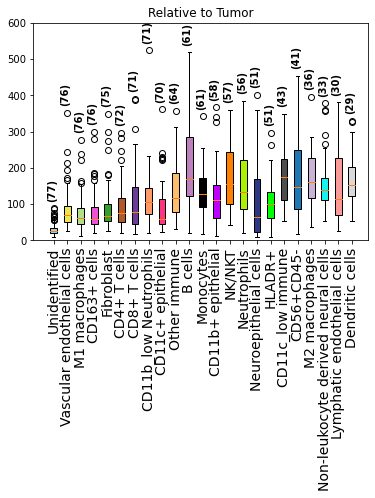

focus cell M1 macrophages does not exist in sample 58


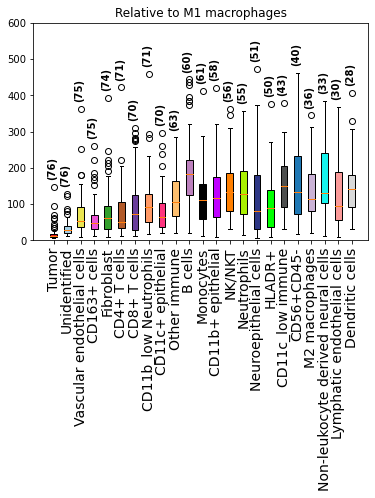

focus cell Vascular endothelial cells does not exist in sample 7


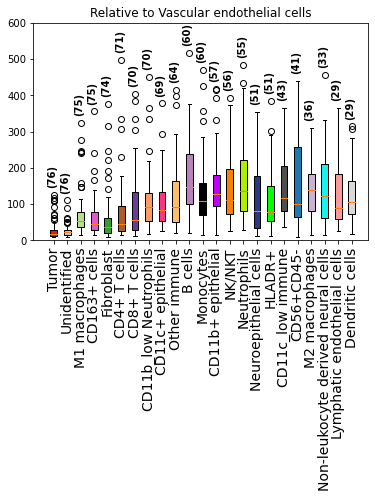

In [16]:
## Figure about spatial features (using only the final set of samples)

type_colors = viz_helper.get_cell_type_colors()

with open(os.path.join('analysis_objects','median_distances_tumor.pickle'), 'rb') as handle:
    median_distances_tumor = pickle.load(handle)
with open(os.path.join('analysis_objects','median_distances_M1.pickle'), 'rb') as handle:
    median_distances_M1 = pickle.load(handle)
with open(os.path.join('analysis_objects','median_distances_vascular.pickle'), 'rb') as handle:
    median_distances_vascular = pickle.load(handle)
with open(os.path.join('analysis_objects','type_counts_trimmed.pickle'), 'rb') as handle:
    type_counts_trimmed = pickle.load(handle)
    
type_counts_trimmed_sorted = dict(sorted(type_counts_trimmed.items(), key=lambda x:x[1], reverse=True)) # sort by count
    
def spatial_feature_plot(median_distances, focus_cell):
    meds = {} # cell type: [median distances] (aggregated across all samples that cell type is found in)
    for pk in median_distances: # for each sample
        if median_distances[pk]: # unless it couldn't be calculated for this sample (focal cell type doesn't exist)
            for tk in median_distances[pk]: # for each of the cell types 
                if tk not in meds:
                    # convert to microns for displaying
                    meds[tk] = [MICRON*median_distances[pk][tk]]
                else:
                    meds[tk].append(MICRON*median_distances[pk][tk])
        else:
            print(f"focus cell {focus_cell} does not exist in sample {pk}")
        
    # save to output text file for reporting
    with open (os.path.join('Figure_3',f'med_distance_{focus_cell}.txt'),'w') as out_file:
        colz = []
        boxplotz = []
        labelz = []
        key_list = list(type_counts_trimmed_sorted.keys())
        key_list.remove(focus_cell) # don't display for focus cell
        for tk in key_list:
            boxplotz.append(meds[tk])
            colz.append(type_colors[tk])
            labelz.append(tk)
            out_file.write(f"cell type: {tk}, mean: {round(np.mean(meds[tk]),3)}, max: {round(np.max(meds[tk]),3)}, variance: {round(np.var(meds[tk]),3)}, std: {round(np.std(meds[tk]),3)}")

        bplot = plt.boxplot(boxplotz,labels=labelz,patch_artist=True)
        for patch, color in zip(bplot['boxes'], colz):
            patch.set_facecolor(color)
        
    ct = 1
    for tk in key_list:
        plt.text(ct-0.5,np.max(meds[tk])+25,f'({len(meds[tk])})',fontsize=10, rotation=90, weight='bold')
        ct+=1
        
    plt.xticks(rotation=90, fontsize=14)
    plt.title(f'Relative to {focus_cell}')
    #plt.ylabel('median distance to nearest neighbor')
    #plt.xlabel('neighbor cell type')
    plt.ylim([0,600])
    plt.xlim([-0.5,ct+0.2])
    plt.savefig(os.path.join('Figure_3',f'3_distance_{focus_cell}.png'),dpi=1000,bbox_inches='tight')
    plt.show()

spatial_feature_plot(median_distances_tumor, TUMOR)
spatial_feature_plot(median_distances_M1, M1)
spatial_feature_plot(median_distances_vascular, VASCULAR)

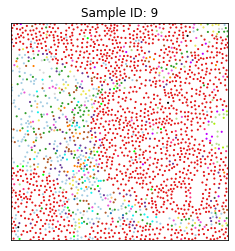

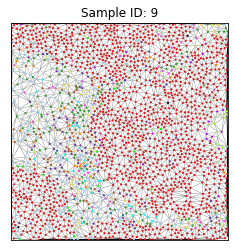

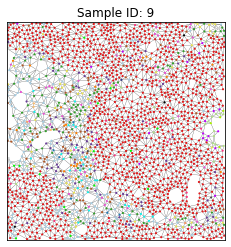

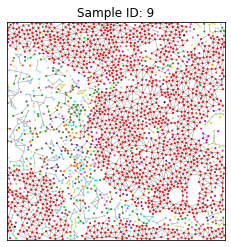

In [3]:
### Spatial network creation supplemental figure 

with open(os.path.join('analysis_objects','points_trimmed.pickle'), 'rb') as handle:
    points = pickle.load(handle)
with open(os.path.join('analysis_objects','cell_types_trimmed.pickle'), 'rb') as handle:
    cell_types = pickle.load(handle)

sample_focus = 9
folder = os.path.join('Figure_3','Net_Creation')
viz_helper.visualize_sample(sample_focus,False,folder,points,cell_types,True)
viz_helper.visualize_triangulation(sample_focus,folder,points,cell_types)
viz_helper.visualize_spatial_network(sample_focus,folder,points,cell_types,SPATIAL_NET_THRESHOLD)
viz_helper.visualize_spatial_network_regions(sample_focus,folder,points,cell_types,SPATIAL_NET_THRESHOLD)

In [4]:
## Generate and save all the spatial networks (only the final set of samples)

with open(os.path.join('analysis_objects','points_trimmed.pickle'), 'rb') as handle:
    points = pickle.load(handle)
with open(os.path.join('analysis_objects','cell_types_trimmed.pickle'), 'rb') as handle:
    cell_types = pickle.load(handle)

regions = False
spatial_nets = {}
distance_dicts = {} # also save all the information re spatial distance between neighbors 
for pk in points.keys():
    spatial_net, _, _, distance_dict = spatial_net_helper.create_spatial_network(pk,points,cell_types,SPATIAL_NET_THRESHOLD,regions)
    spatial_nets[pk] = spatial_net
    distance_dicts[pk] = distance_dict
    
with open(os.path.join('analysis_objects','spatial_nets.pickle'), 'wb') as handle:
    pickle.dump(spatial_nets, handle)
with open(os.path.join('analysis_objects','distance_dicts.pickle'), 'wb') as handle:
    pickle.dump(distance_dicts, handle)

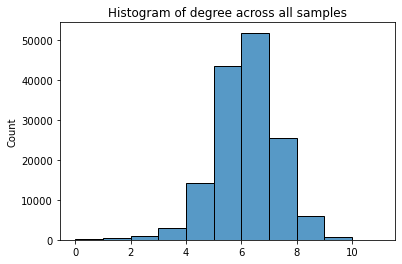

In [5]:
## Network properties

with open(os.path.join('analysis_objects','spatial_nets.pickle'), 'rb') as handle:
    spatial_nets = pickle.load(handle)

degs = []
for pk in spatial_nets.keys():
    for node in spatial_nets[pk].nodes():
        degs.append(spatial_nets[pk].degree[node])
    
# Aggregate degree distribution plot (across all samples)
plt.title('Histogram of degree across all samples')
sns.histplot(data=degs,binwidth=1)
plt.savefig(os.path.join('Figure_3','Net_Properties','degree_histogram.png'),dpi=1000,bbox_inches='tight')
plt.show()

In [6]:
## Generate median distances between spatial net neighbors across the whole dataset and save (using only included samples)

type_colors = viz_helper.get_cell_type_colors()
unique_types = list(type_colors.keys())

with open(os.path.join('analysis_objects','points_trimmed.pickle'), 'rb') as handle:
    points = pickle.load(handle)
with open(os.path.join('analysis_objects','cell_types_trimmed.pickle'), 'rb') as handle:
    cell_types = pickle.load(handle)
with open(os.path.join('analysis_objects','distance_dicts.pickle'), 'rb') as handle:
    distance_dicts = pickle.load(handle)
    
distance_dict = {} # Aggregated dictionary of distances between cell type pairs across all the spatial networks
for pk in points.keys():
    curr_distance_dict = distance_dicts[pk]
    for pair in curr_distance_dict:
        if pair in distance_dict:
            distance_dict[pair] = distance_dict[pair] + curr_distance_dict[pair] # concatenate two lists together
        elif (pair[1],pair[0]) in distance_dict:
            distance_dict[(pair[1],pair[0])] = distance_dict[(pair[1],pair[0])] + curr_distance_dict[pair]
        else:
            distance_dict[pair] = curr_distance_dict[pair]

# Median distances
type_indices = {} # cell type indices in the matrix
ct = 0 
for typey in unique_types: # unique types
    type_indices[typey] = ct
    ct +=1
                                                                                                                                                            
# Create a matrix between all cell types 
final_med = np.empty((len(unique_types),len(unique_types)))
final_med[:] = np.nan
for type_pair in distance_dict:
    final_med[type_indices[type_pair[0]],type_indices[type_pair[1]]] = np.median(distance_dict[type_pair])
    final_med[type_indices[type_pair[1]],type_indices[type_pair[0]]] = np.median(distance_dict[type_pair])

# save the numpy matrix
final_med.dump(os.path.join('analysis_objects','median_distances'))

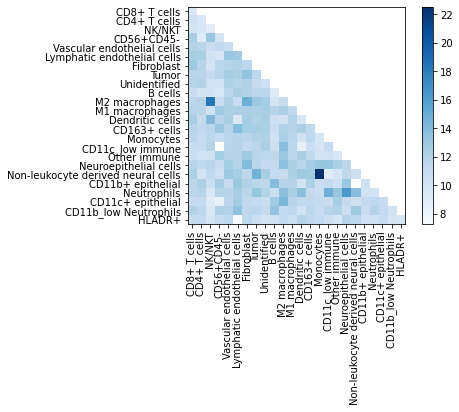

In [7]:
## Supplemental network feature plot - median distances between cells of different types
type_colors = viz_helper.get_cell_type_colors()
md = np.load(os.path.join('analysis_objects','median_distances'),allow_pickle=True)
md = md*MICRON # convert to microns for the figure
lower = np.tril(md)# just visualize lower triangle because symmetrical
lower[lower == 0] = np.nan
labels = list(type_colors.keys())
plt.xticks(np.arange(len(type_colors)), labels=labels,rotation=90)
plt.yticks(np.arange(len(type_colors)), labels=labels)
c = plt.imshow(lower, cmap='Blues', interpolation='nearest')
plt.colorbar(c)
plt.savefig(os.path.join('Figure_3','Net_Properties','median_neighbor_distances.png'),dpi=1000,bbox_inches='tight')
plt.show()

In [8]:
## Collect region size information 

with open(os.path.join('analysis_objects','points_trimmed.pickle'), 'rb') as handle:
    points = pickle.load(handle)
with open(os.path.join('analysis_objects','cell_types_trimmed.pickle'), 'rb') as handle:
    cell_types = pickle.load(handle)

# Dictionary of cell type : list of region sizes
region_sizes = {}

# For cell type proportions (Repeated)
region_sizes_rep = {}

# Non-pooled to create features
region_sizes_samples = {}

regions = True

for pk in points.keys():
    net,_,_,_  = spatial_net_helper.create_spatial_network(pk,points,cell_types,SPATIAL_NET_THRESHOLD,regions)
    connected = nx.connected_components(net)
    curr_region_sizes = {}
    for conn in connected:
        ct = 0 
        for n in conn:
            if ct == 0:
                curr_type = net.nodes[n]["cell type"]
            else:
                if net.nodes[n]["cell type"] != curr_type:
                    print("issue! not all same type in the region!")
            ct+=1
            
        # Save in aggregate dictionaries for plotting
        if curr_type not in region_sizes:
            region_sizes[curr_type] = [len(conn)]
            region_sizes_rep[curr_type] = [len(conn)]
            for k in range(0,len(conn)-1): # repeat the record for every cell in the connected region
                region_sizes_rep[curr_type].append(len(conn))
        else:
            region_sizes[curr_type].append(len(conn))
            for k in range(0,len(conn)):
                region_sizes_rep[curr_type].append(len(conn))
                
        # For calculating mean region size for each cell type for the sample
        if curr_type not in curr_region_sizes:
            curr_region_sizes[curr_type] = [len(conn)]
        else:
            curr_region_sizes[curr_type].append(len(conn))
            
    # save mean region size for each type per sample
    for key in curr_region_sizes:
        curr_region_sizes[key] = np.mean(curr_region_sizes[key])
    region_sizes_samples[pk] = curr_region_sizes

with open(os.path.join('analysis_objects','region_sizes.pickle'), 'wb') as handle:
    pickle.dump(region_sizes, handle)
with open(os.path.join('analysis_objects','region_sizes_rep.pickle'), 'wb') as handle:
    pickle.dump(region_sizes_rep, handle)
with open(os.path.join('analysis_objects','region_sizes_samples.pickle'), 'wb') as handle:
    pickle.dump(region_sizes_samples, handle)

Maximum region size for CD8+ T cells: 73
Maximum region size for CD4+ T cells: 202
Maximum region size for NK/NKT: 11
Maximum region size for CD56+CD45-: 185
Maximum region size for Vascular endothelial cells: 124
Maximum region size for Lymphatic endothelial cells: 47
Maximum region size for Fibroblast: 158
50% of regions of Tumor are under / over 2 cells
Maximum region size for Tumor: 2190
Maximum region size for Unidentified: 1024
Maximum region size for B cells: 178
Maximum region size for M2 macrophages: 55
Maximum region size for M1 macrophages: 38
Maximum region size for Dendritic cells: 17
Maximum region size for CD163+ cells: 38
Maximum region size for Monocytes: 28
Maximum region size for CD11c_low immune: 5
Maximum region size for Other immune: 8
Maximum region size for Neuroepithelial cells: 1288
Maximum region size for Non-leukocyte derived neural cells: 73
Maximum region size for CD11b+ epithelial: 349
Maximum region size for Neutrophils: 53
Maximum region size for CD11c+

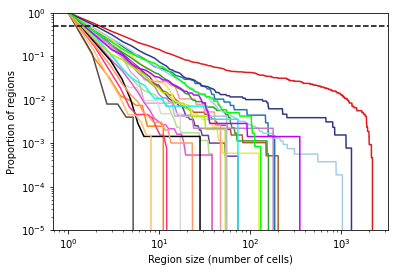

CD8+ T cells - 50% found in regions size 3 or larger
CD4+ T cells - 50% found in regions size 3 or larger
NK/NKT - 50% found in regions size 2 or larger
CD56+CD45- - 50% found in regions size 14 or larger
Vascular endothelial cells - 50% found in regions size 4 or larger
Lymphatic endothelial cells - 50% found in regions size 4 or larger
Fibroblast - 50% found in regions size 5 or larger
Tumor - 50% found in regions size 1071 or larger
Unidentified - 50% found in regions size 11 or larger
B cells - 50% found in regions size 4 or larger
M2 macrophages - 50% found in regions size 3 or larger
M1 macrophages - 50% found in regions size 2 or larger
Dendritic cells - 50% found in regions size 2 or larger
CD163+ cells - 50% found in regions size 2 or larger
Monocytes - 50% found in regions size 2 or larger
CD11c_low immune - 50% found in regions size 2 or larger
Other immune - 50% found in regions size 2 or larger
Neuroepithelial cells - 50% found in regions size 226 or larger
Non-leukocyte d

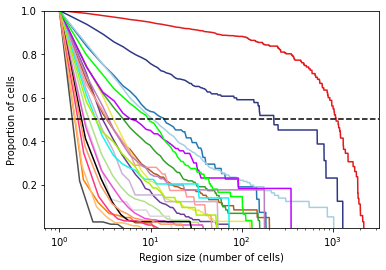

In [9]:
## 4B - Region sizes figures (print some details for reporting)

with open(os.path.join('analysis_objects','region_sizes.pickle'), 'rb') as handle:
    region_sizes = pickle.load(handle)
with open(os.path.join('analysis_objects','region_sizes_rep.pickle'), 'rb') as handle:
    region_sizes_rep = pickle.load(handle)
    
type_colors = viz_helper.get_cell_type_colors()
unique_types = list(type_colors.keys())

# Region size plot 1 - log-log CCDF - Region size vs. Proportion of regions
for cell_type in unique_types:
    values = np.array(region_sizes[cell_type])
    count, bins_count = np.histogram(values, bins=np.max(region_sizes[cell_type])+1)
    pdf = count / sum(count)
    cdf = np.cumsum(pdf)
    ccdf = 1 - cdf
    ccdf = np.insert(ccdf, 0, 1, axis=0)
    xs = np.linspace(np.min(region_sizes[cell_type]), np.max(region_sizes[cell_type])+1,len(ccdf))
    fif_index = (np.abs(ccdf-0.5)).argmin()
    if cell_type == "Tumor":
        print(f"50% of regions of {cell_type} are under / over {round(xs[fif_index])} cells")
    print(f"Maximum region size for {cell_type}: {np.max(region_sizes[cell_type])}")
    plt.loglog(xs, ccdf, color=type_colors[cell_type], label=cell_type)
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Region size (number of cells)")
plt.ylabel("Proportion of regions")
plt.axhline(y = 0.5, color = 'k', linestyle = '--')
plt.ylim([0.00001,1])
plt.savefig(os.path.join('Figure_3','region_size_1.png'),dpi=1000,bbox_inches='tight')
plt.show()

# Region size plot 2 - Proportion of cells found within 
# regions of size equal or larger than a given value (logarithmic x axis)

for cell_type in unique_types:
    values = np.array(region_sizes_rep[cell_type])
    count, bins_count = np.histogram(values, bins=np.max(region_sizes_rep[cell_type])+1)
    pdf = count / sum(count)
    cdf = np.cumsum(pdf)
    ccdf = 1 - cdf
    ccdf = np.insert(ccdf, 0, 1, axis=0)
    xs = np.linspace(np.min(region_sizes_rep[cell_type]), np.max(region_sizes_rep[cell_type]),len(ccdf))
    fif_index = (np.abs(ccdf-0.5)).argmin()
    print(f"{cell_type} - 50% found in regions size {round(xs[fif_index])} or larger")
    plt.semilogx(xs, ccdf, color=type_colors[cell_type], label=cell_type)
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Region size (number of cells)")
plt.ylabel("Proportion of cells")
plt.axhline(y = 0.5, color = 'k', linestyle = '--')
plt.ylim([0.00001,1])
plt.savefig(os.path.join('Figure_3','region_size_2.png'),dpi=1000,bbox_inches='tight')
plt.show()

In [10]:
## Generate assortativity coefficients
with open(os.path.join('analysis_objects','spatial_nets.pickle'), 'rb') as handle:
    spatial_nets = pickle.load(handle)
    
type_colors = viz_helper.get_cell_type_colors()
unique_types = list(type_colors.keys())
    
assorts = {} # {assortativity coefficients cell type : [list]} (for visualizing across samples)
assorts_samples = {}  # for generating features - {fov_int: {cell type: assort}}

for typee in unique_types:
    assorts[typee] = []

edge_ct = 0 
for pk in spatial_nets.keys():
    assorts_samples[pk] = {}
    net = spatial_nets[pk]
    for key in unique_types:
        if key in set(cell_types[pk]) and cell_types[pk].count(key) != 1:
            assort = nx.attribute_assortativity_coefficient(net,key)    
            assorts[key].append(assort)
            assorts_samples[pk][key] = assort
        if key in set(cell_types[pk]) and cell_types[pk].count(key) == 1: # edge case
            edge_ct += 1
            # To see the 147 cases of only 1 cell identified of a cell type in a sample
            #print(f"edge case - cell type exists in sample but only 1 identified so no assortativity - {pk} - {key}")
            
print(f"number of times only one cell of a type found in a sample: {edge_ct}")
with open(os.path.join('analysis_objects','assorts.pickle'), 'wb') as handle:
    pickle.dump(assorts, handle)
with open(os.path.join('analysis_objects','assorts_samples.pickle'), 'wb') as handle:
    pickle.dump(assorts_samples, handle)

number of times only one cell of a type found in a sample: 147


NK/NKT : mean value 0.023890853580109207
CD11c_low immune : mean value 0.025528345464078082
CD11b_low Neutrophils : mean value 0.033070992444683645
Other immune : mean value 0.03552383838897761
Monocytes : mean value 0.042637235430937434
CD11c+ epithelial : mean value 0.04649995079290218
CD163+ cells : mean value 0.054921423717262614
Neutrophils : mean value 0.06633433766083244
CD11b+ epithelial : mean value 0.07892850879201752
HLADR+ : mean value 0.08178702427050524
CD4+ T cells : mean value 0.08729590942412427
M1 macrophages : mean value 0.0913273274054887
Non-leukocyte derived neural cells : mean value 0.09201980715767233
CD56+CD45- : mean value 0.09485688389390534
Dendritic cells : mean value 0.10224712678549619
M2 macrophages : mean value 0.11107324049554555
B cells : mean value 0.11158574571881584
Lymphatic endothelial cells : mean value 0.11807154381764388
CD8+ T cells : mean value 0.12499752426741186
Fibroblast : mean value 0.1611330602245974
Neuroepithelial cells : mean value 

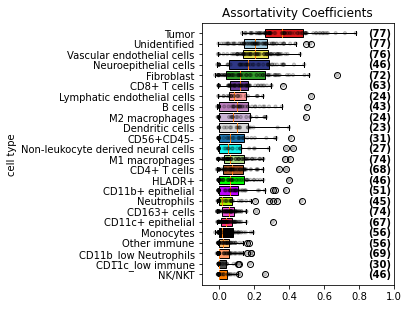

In [11]:
## Assortativities figure
with open(os.path.join('analysis_objects','assorts.pickle'), 'rb') as handle:
    assorts = pickle.load(handle)

type_colors = viz_helper.get_cell_type_colors()
f = plt.figure()
cm = 1/2.54  # centimeters in inches
f.set_figwidth(8.75*cm)
f.set_figheight(12.25*cm)
assorts = dict(sorted(assorts.items(), key=lambda x:np.mean(x[1]))) # sort by mean assortativity
labels = list(assorts.keys())
assort_colors = []
for i in range(0,len(labels)):
    assort_colors.append(type_colors[labels[i]])
bplot = plt.boxplot(list(assorts.values()),vert=False,labels=labels,patch_artist=True,zorder=1,widths = 0.8)
for patch, color in zip(bplot['boxes'], assort_colors):
    patch.set_facecolor(color)
ct = 1
for key in assorts:
    plt.scatter(assorts[key],[ct]*len(assorts[key]),color='black',alpha=0.2,zorder=2,s=[10]*len(assorts[key]))
    print(f"{key} : mean value {np.mean(assorts[key])}") # report mean values
    plt.text(0.85,ct-0.3,f'({len(assorts[key])})',fontsize=10, weight='bold')
    ct +=1
plt.title("Assortativity Coefficients")
plt.ylabel("cell type")
plt.xlim([-0.1,1])
plt.ylim([0,len(labels)+1])
plt.savefig(os.path.join('Figure_4','assortativities.png'), dpi=1000, bbox_inches='tight')
plt.show()

In [12]:
## Contact enrichment scores (only with final set of samples)

# set seed to reproduce the same values (randomization for null models)
np.random.seed(30)

with open(os.path.join('analysis_objects','points_trimmed.pickle'), 'rb') as handle:
    points = pickle.load(handle)
with open(os.path.join('analysis_objects','cell_types_trimmed.pickle'), 'rb') as handle:
    cell_types = pickle.load(handle)
with open(os.path.join('analysis_objects','spatial_nets.pickle'), 'rb') as handle:
    spatial_nets = pickle.load(handle)
    
contact_enrichments_tumor = {}
contact_enrichments_M1 = {}
contact_enrichments_vascular = {}
for pk in points.keys():
    net = spatial_nets[pk]
    points_ex = points[pk]
    types_ex = cell_types[pk]
    contact_enrichments_tumor[pk] = spatial_net_helper.contact_enrichment_score(pk, net, TUMOR, points_ex, types_ex)
    contact_enrichments_M1[pk] = spatial_net_helper.contact_enrichment_score(pk, net, M1, points_ex, types_ex)
    contact_enrichments_vascular[pk] = spatial_net_helper.contact_enrichment_score(pk, net, VASCULAR, points_ex, types_ex)

with open(os.path.join('analysis_objects','contact_enrichments_tumor.pickle'), 'wb') as handle:
    pickle.dump(contact_enrichments_tumor, handle)
with open(os.path.join('analysis_objects','contact_enrichments_M1.pickle'), 'wb') as handle:
    pickle.dump(contact_enrichments_M1, handle)
with open(os.path.join('analysis_objects','contact_enrichments_vascular.pickle'), 'wb') as handle:
    pickle.dump(contact_enrichments_vascular, handle)

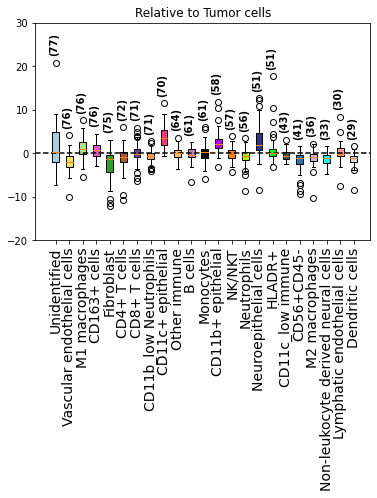

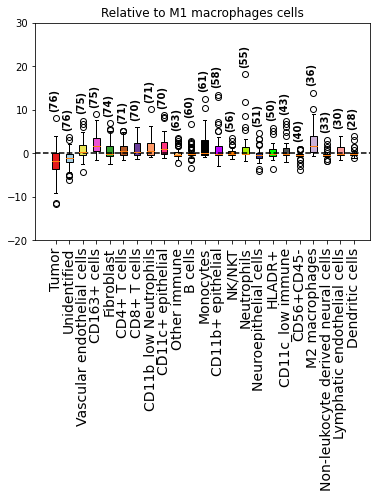

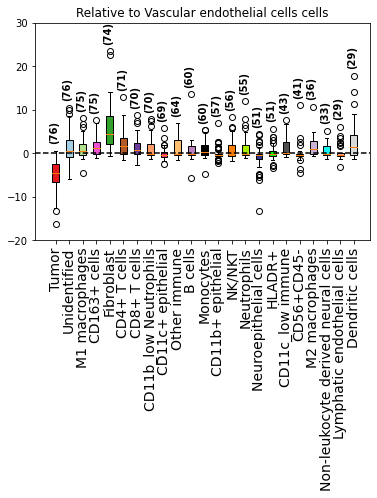

In [13]:
## 4D - Contact enrichment figure

type_colors = viz_helper.get_cell_type_colors()
with open(os.path.join('analysis_objects','contact_enrichments_tumor.pickle'), 'rb') as handle:
    contact_enrichments_tumor = pickle.load(handle)
with open(os.path.join('analysis_objects','contact_enrichments_M1.pickle'), 'rb') as handle:
    contact_enrichments_M1 = pickle.load(handle)
with open(os.path.join('analysis_objects','contact_enrichments_vascular.pickle'), 'rb') as handle:
    contact_enrichments_vascular = pickle.load(handle)
with open(os.path.join('analysis_objects','type_counts_trimmed.pickle'), 'rb') as handle:
    type_counts_trimmed = pickle.load(handle)
    
type_counts_trimmed_sorted = dict(sorted(type_counts_trimmed.items(), key=lambda x:x[1], reverse=True)) # sort by count
          
def contact_plot(contact_enrichments, focus_cell):
    contacts = {} # cell type: [contact scores]
    
    for pk in contact_enrichments:
        if contact_enrichments[pk]:
            for tk in contact_enrichments[pk]:
                if tk not in contacts:
                    contacts[tk] = [contact_enrichments[pk][tk]]
                else:
                    contacts[tk].append(contact_enrichments[pk][tk])
    colz = []
    boxplotz = []
    labelz = []
    key_list = list(type_counts_trimmed_sorted.keys())
    key_list.remove(focus_cell)
    for tk in key_list:
        boxplotz.append(contacts[tk])
        colz.append(type_colors[tk])
        labelz.append(tk)
        
    bplot = plt.boxplot(boxplotz,labels=labelz,patch_artist=True)
    for patch, color in zip(bplot['boxes'], colz):
        patch.set_facecolor(color)
    
    ct = 1
    for tk in key_list:
        plt.text(ct-0.5,np.max(contacts[tk])+2,f'({len(contacts[tk])})',fontsize=10, rotation=90, weight='bold')
        ct+=1

    plt.xticks(rotation=90, fontsize=14)
    plt.title(f'Relative to {focus_cell} cells')
    #plt.ylabel('contact enrichment score')
    #plt.xlabel('cell type')
    plt.axhline(y=0, color='k', linestyle='--')
    plt.ylim([-20,30])
    plt.xlim([-0.5,ct+0.2])
    plt.savefig(os.path.join('Figure_3',f'3_contact_{focus_cell}.png'),dpi=1000,bbox_inches='tight')
    plt.show()

contact_plot(contact_enrichments_tumor, TUMOR)
contact_plot(contact_enrichments_M1, M1)
contact_plot(contact_enrichments_vascular, VASCULAR)